In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchinfo import summary
from sklearn.preprocessing import MinMaxScaler

import joblib
import pennylane as qml
torch.manual_seed(42)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [29]:
train_data=pd.read_csv('./assets/processed dataset/train dataset.csv')
validation_data=pd.read_csv('./assets/processed dataset/validation dataset.csv')

In [30]:
#Data scaling
scaler=MinMaxScaler()
normalized_train_data=scaler.fit_transform(train_data)
joblib.dump(scaler, "./assets/scaler.gz") 
print(normalized_train_data[0])
normalized_validation_data=scaler.transform(validation_data)
print(normalized_validation_data[0])

[0.         0.19290466 0.20735786 0.21236002]
[0.         0.27937916 0.25139353 0.35296557]


In [31]:
#Prepearing X and Y for training and validation
# Setting THE SEQUENCE LENGTH 
seq_length=180
#initialized to a empty 1d list
X_train=[]
Y_train=[]
X_validate=[]
Y_validate=[]
for i in range(seq_length,train_data.shape[0]):
    #Data from 0 to 59TH index
    X_train.append(normalized_train_data[i-seq_length:i])
    #T2M AT THE 60TH index
    Y_train.append(normalized_train_data[i])

for i in range(seq_length,validation_data.shape[0]):
    #Data from 0 to 59TH index
    X_validate.append(normalized_validation_data[i-seq_length:i])
    #T2M AT THE 60TH index
    Y_validate.append(normalized_validation_data[i])

# converting into numpy arrays
X_train,Y_train=np.array(X_train),np.array(Y_train)
#change to 2d array from 1d array
Y_train=Y_train.reshape(-1,4)
print(X_train.shape,Y_train.shape)

X_validate,Y_validate=np.array(X_validate),np.array(Y_validate)
Y_validate=Y_validate.reshape(-1,4)
print(X_validate.shape,Y_validate.shape)

X_train = Variable(torch.Tensor(X_train))
Y_train = Variable(torch.Tensor(Y_train))
print(X_train.shape,Y_train.shape)

X_validate = Variable(torch.Tensor(X_validate))
Y_validate = Variable(torch.Tensor(Y_validate))
print(X_validate.shape,Y_validate.shape)

(10813, 180, 4) (10813, 4)
(2176, 180, 4) (2176, 4)
torch.Size([10813, 180, 4]) torch.Size([10813, 4])
torch.Size([2176, 180, 4]) torch.Size([2176, 4])


In [32]:
#Defining quantum layer
n_qubits = 4
n_layers=6
weight_shapes = {"weights": (n_layers, n_qubits)}
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev,interface='torch')
def circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    exp_val=[qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]
    return tuple(exp_val)

# qml.drawer.use_style("black_white")
# fig,ax=qml.draw_mpl(circuit)([0.26,0.28,3.31,0.85],torch.randn(6,4))
# plt.show()
qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)
qlayer

<Quantum Torch Layer: func=circuit>

In [33]:
#HYBRID QLSTM Network definition
class NETWORK_HYBRID_QLSTM(nn.Module):

    def __init__(self,num_classes,input_size,hidden_size,num_layers):
        super(NETWORK_HYBRID_QLSTM,self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm1=nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True).to(device)
        self.fc1=nn.Linear(hidden_size,n_qubits)
        self.qlayer=qlayer
        self.fc2=nn.Linear(n_qubits,num_classes)
    
    def forward(self,x):
        output_lstm1, (h_n,c_n) = self.lstm1(x)
        output_fc1=self.fc1(output_lstm1[:,-1,:])
        input_q=output_fc1        
        output_q=self.qlayer(input_q)
        output_fc2=self.fc2(output_q).to(device)
        return output_fc2

In [38]:
#Initializing model with parameters
num_epochs=200
learning_rate=0.01
input_size=4
hidden_size=16
num_layers=2
num_classes=4

model=NETWORK_HYBRID_QLSTM(num_classes,input_size, hidden_size,num_layers)
model.to(device)

NETWORK_HYBRID_QLSTM(
  (lstm1): LSTM(4, 16, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=16, out_features=4, bias=True)
  (qlayer): <Quantum Torch Layer: func=circuit>
  (fc2): Linear(in_features=4, out_features=4, bias=True)
)

In [39]:
# DEFINE OPTIMIZER
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Lists to store training losses for plotting the training curve
train_losses = []
valid_losses=[]
#batch gradient descent
# TRAIN THE MODEL:
for epoch in range(1,num_epochs+1):
    model.train()
    outputs = model(X_train.to(device))
    optimizer.zero_grad()
    # obtain the loss function
    loss = criterion(outputs, Y_train.to(device))
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    model.eval()
    with torch.no_grad():
        valid_outputs=model(X_validate.to(device))
        valid_loss=criterion(valid_outputs,Y_validate.to(device))
        valid_losses.append(valid_loss.item())
    if epoch % 1 == 0:
        print("Epoch: %d, training loss: %1.5f, validation loss: %1.5f" % (epoch, loss.item(),valid_loss.item()))

Epoch: 1, training loss: 0.33544, validation loss: 0.31612
Epoch: 2, training loss: 0.29375, validation loss: 0.27703
Epoch: 3, training loss: 0.25596, validation loss: 0.24369
Epoch: 4, training loss: 0.22392, validation loss: 0.22047
Epoch: 5, training loss: 0.20188, validation loss: 0.20627
Epoch: 6, training loss: 0.18861, validation loss: 0.18668
Epoch: 7, training loss: 0.17023, validation loss: 0.16153
Epoch: 8, training loss: 0.14666, validation loss: 0.13535
Epoch: 9, training loss: 0.12231, validation loss: 0.11181
Epoch: 10, training loss: 0.10065, validation loss: 0.09281
Epoch: 11, training loss: 0.08346, validation loss: 0.07859
Epoch: 12, training loss: 0.07088, validation loss: 0.06831
Epoch: 13, training loss: 0.06203, validation loss: 0.06090
Epoch: 14, training loss: 0.05581, validation loss: 0.05541
Epoch: 15, training loss: 0.05129, validation loss: 0.05121
Epoch: 16, training loss: 0.04786, validation loss: 0.04798
Epoch: 17, training loss: 0.04524, validation los

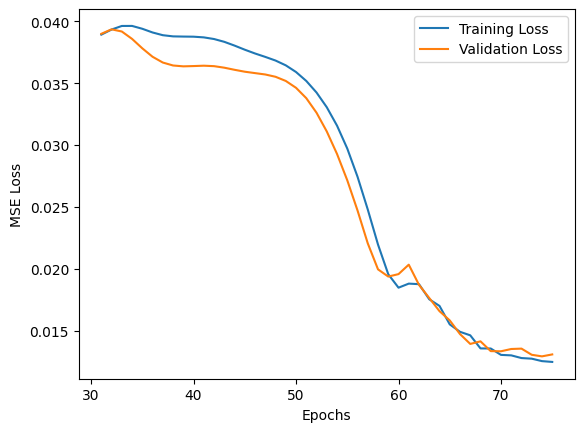

In [48]:
# Plotting the training curve
epochs=range(1,num_epochs+1)
st=30;end=75
plt.plot( epochs[st:end],train_losses[st:end], label='Training Loss')
plt.plot(epochs[st:end],valid_losses[st:end], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [41]:
torch.save(model.state_dict(),'./assets/trainedmodels/hybrid_qlstm_state.pt')